# Atmospheric Phase Statistics

First we import the `ceo` module.

In [1]:
import sys
import numpy as np
import math
import ceo
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Then a `Source` object is created. You must specify the photometric bandwidth.
The zenith and azimuth angles and the source height are optional parameters set by default to 0,0 and $\infty$, respectively.
The wavefront shape is also optional set to (0,0) per default, meaning that the source won't have a wavefront.

In [2]:
n = 64
src = ceo.Source("K",resolution=(n,n))

An `Atmosphere` object is created by specifying first the $r_0$ and $L_0$, the the optional number of layers, layer altitudes, fractional powers, wind speeds and directions.
Here a single atmospheric layer at the ground is created.

In [3]:
atm = ceo.Atmosphere(0.15,25)
#atm = ceo.GmtAtmosphere(0.15,30)

A phase screen is computed by passing the source object, the number of sources in the source object, the sampling step and number in the X and y directions and the time delay.

In [4]:
atm.get_phase_screen(src,0.1,n,0.1,n,0.0)

The phase screen is written in the phase attribute of the source object.
The phase attribute is a `cuFloatArray` object that contains a pointer to the phase screen on the device.
To copy the data to the host, simply call the `host` method of the `cuFloatArray` object.

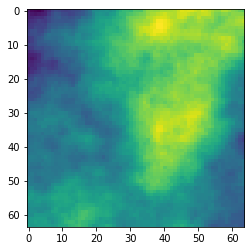

In [5]:
imshow(src.phase.host(units='micron'))

## Variance

The atmosphere turbulence phase can also be computed for arbitrary coordinates $[x,y]$.
The coordinates are defined as `cuFloatArray` objects setting the `host_data` attributes to a numpy array.
A copy on the device of `host_data` is immediately made.

In [6]:
x = ceo.cuFloatArray(host_data=np.array([0]))
y = ceo.cuFloatArray(host_data=np.array([0]))

Now lets define a function to compute single phase values.
By calling the `reset` method of the `Atmosphere` object, we ensure to have a set of independent variates.
`reset` re-draw the random number used to compute the phase values. 

In [7]:
def var_eval(x,y,atm,src):
    atm.reset()
    ps = atm.get_phase_values(x,y,src,0.0)
    return ps.host()

The function is called a number of times and the phase values are saved in `ps`

In [8]:
ps_fun = lambda z: [var_eval(x,y,atm,src) for k in range(z) ]

The variance of the phase is computed next.
The phase is given in meter, so it is converted in radian.

In [9]:
ps = ps_fun(1000)
wavenumber = 2*math.pi/0.55e-6
num_var = np.var(ps)*(wavenumber**2)

The numerical variance is compared to the theoretical variance.

In [10]:
the_var = ceo.phaseStats.variance(atmosphere=atm)
print("Theoretical variance: %6.2frd^2" % the_var)
print("Numerical variance  : %6.2frd^2" % num_var)
print("Variance ratio      : %8.5f" % (num_var/the_var))

Theoretical variance: 435.68rd^2
Numerical variance  : 435.83rd^2
Variance ratio      :  1.00034


In [14]:
the_var = ceo.phaseStats.variance(atmosphere=atm)
print("Theoretical variance: %6.2fnm" % (np.sqrt(the_var)*715/2/np.pi))
print("Numerical variance  : %6.2fnm" % (np.sqrt(num_var)*715/2/np.pi))
print("Variance ratio      : %8.5f" % (num_var/the_var))

Theoretical variance: 2375.24nm
Numerical variance  : 2375.65nm
Variance ratio      :  1.00034


## Structure function

The $[x,y]$ plane is randomly sampled in the range $[-2\mathcal L_0,+2\mathcal L_0]$.

In [16]:
n_points = 1000
x = np.random.uniform(-1,1,n_points)*atm.L0*2
y = np.random.uniform(-1,1,n_points)*atm.L0*2
z_xy = x + 1j*y

Data are copied to the device:

In [17]:
cu_x = ceo.cuFloatArray(host_data=z_xy.real)
cu_y = ceo.cuFloatArray(host_data=z_xy.imag)

The structure function is computed for baseline $\rho$ randomly distributed on a circle.

In [18]:
phi = np.random.uniform(0,2*math.pi,n_points)
rho,rho_step = np.linspace(0,atm.L0*4,21,retstep=True)
rho[0] = 0.1

The differential phase is computed for `n_sample` independent variates.

The structure function of the independent variates is computed first.
The structure function `sf` is distributed on a circle of radius $\rho$ where it should be constant.

The mean and standart deviation on the circle of the structure function `sf` is evaluated in `mean_sf` and `std_sf`.

In [19]:
n_sample = 1000
d_ps = np.zeros( (n_points, n_sample) , dtype=np.float32)
mean_sf = np.zeros( rho.size)
std_sf  = np.zeros( rho.size)

In [22]:
print("rho sample: %d" % (rho.size))
for k_rho in range(rho.size):
    sys.stdout.write("\r[%d]" % k_rho)
    z_rho = rho[k_rho]*np.exp(1j*phi)
    z_xy_rho = z_xy + z_rho
    cu_x_rho = ceo.cuFloatArray(host_data=z_xy_rho.real)
    cu_y_rho = ceo.cuFloatArray(host_data=z_xy_rho.imag)
    for k in range(n_sample):
        atm.reset()
        ps     = atm.get_phase_values(cu_x,cu_y,src,0.0).host()
        ps_rho = atm.get_phase_values(cu_x_rho,cu_y_rho,src,0.0).host()
        d_ps[:,k]   = ps - ps_rho
    sf = d_ps.var(axis=1)*(wavenumber**2)
    mean_sf[k_rho] = sf.mean()
    std_sf[k_rho]  = sf.std()

rho sample: 21
[20]

In [23]:
sf_th = ceo.phaseStats.structure_function(rho,atmosphere=atm)

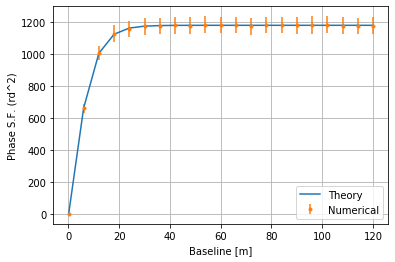

In [24]:
plot(rho,sf_th,label='Theory')
errorbar(rho,mean_sf,yerr=std_sf,marker='.',linestyle='none',label='Numerical')
grid()
xlabel('Baseline [m]')
ylabel('Phase S.F. (rd^2)')
legend()